# photometry_test.ipynb

Visitごとに、セレクトされたデータを用いて開口測光を行い、スポットの位置(緯度・経度)や明るさ(EFPの明るさとバックグラウンド)を測定し保存する。

In [36]:
import numpy as np
import math
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAperture
from photutils.aperture import CircularAnnulus
from numba import njit

import spiceypy as spice
import hstprojimage as hst
from TScmap import TScmap

In [37]:
spice.furnsh('kernel/cassMetaK.txt')

# 北半球
filename = 'data/red/2014/006_v06/jup_14-006-02-35-18_0030_v06_stis_f25srf2_flatproj.fits'
filename = 'data/red3/EUROPA/2022/274_v17/jup_22-274-19-02-08_0030_v17_stis_f25srf2_flatproj.fits'
# 南半球
# filename = 'data/red3/EUROPA/2022/185_v09/jup_22-185-18-43-04_0030_v09_stis_f25srf2_flatproj.fits'
ext = 0
hext = 1
with fits.open(filename) as hdul:
    image = hdul[ext].data # .astype(np.float32)
    h = hdul[hext].header

# HST data
moon = 'EUROPA'
h = hst.HSTProjImage(filename)
h.readHSTFile()
h.MOON = moon
IMG = h.image
hem = h.alm.hemisph
print('hem', hem)

OBS DATE 2022-10-01T19:02:08
hem north


(1000, 1000)


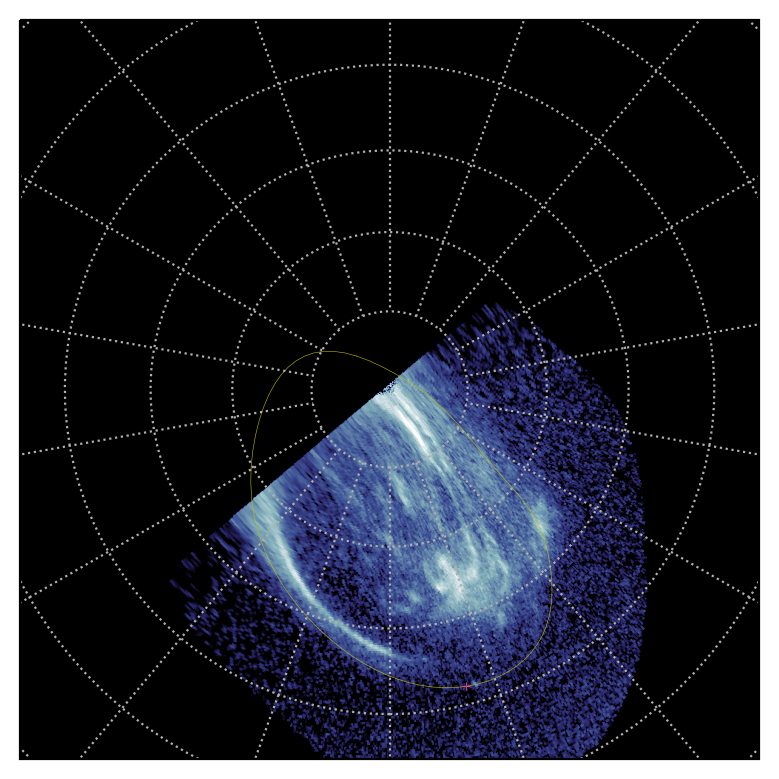

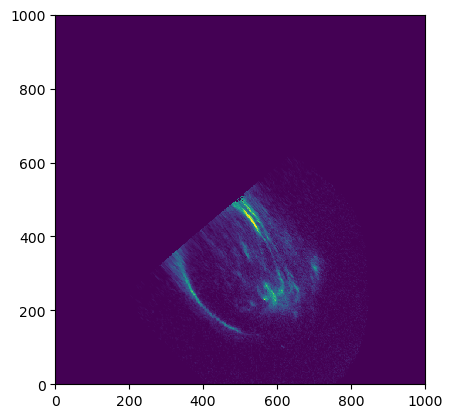

In [38]:
extdeg = 45.0
fig, ax = plt.subplots(dpi=200)
ax, dimage, gl = h.tvPolar(ax, vmin=10, vmax=2000,
                  draw_labels=False, refmainoval=False,
                  satovals=['eu'],
                  reflon=None,
                  # reflon=h.alm.cml,
                  ext=extdeg,
                  )

print(dimage.shape)
Npx = dimage.shape[0]
dimage = dimage[:,::-1]
if hem == 'south':
    dimage = dimage[:,::-1]
fig, ax = plt.subplots(dpi=100)
ax.set_aspect('equal')
ax.pcolormesh(dimage)
plt.show()

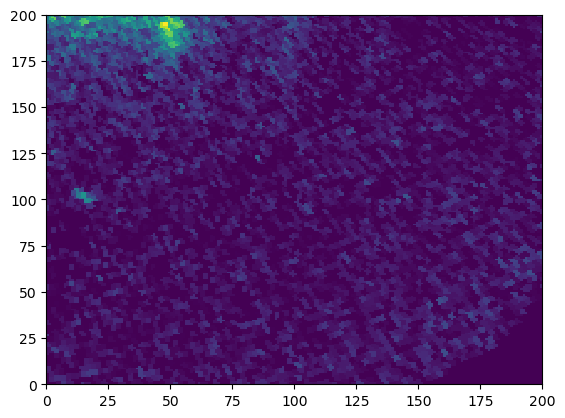

In [39]:
x0, x1 = 600, 800
y0, y1 = 0, 200
img = dimage[y0:y1,x0:x1]
fig, ax = plt.subplots(dpi=100)
ax.pcolormesh(img)
plt.show()

開口測光 (Aperture Photometry)

In [40]:
# Find bright spots
mean = np.average(img)
median = np.median(img)
std = np.std(img)
print('STD', std)
thres = 1.2*std
daofind = DAOStarFinder(fwhm=2.0, threshold=thres)  
# https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html
# DAOStarFinderのfluxの定義 ... stdのfactor倍
sources = daofind(img)  
print(sources)

STD 51.081787
 id     xcentroid      ...        flux                 mag          
--- ------------------ ... ------------------ ----------------------
  1  6.321455048969695 ... 1.0440807342529297  -0.046835205202245045
  2  125.3958447820069 ... 1.4856524467468262   -0.42979305634380094
  3 136.01456957108547 ... 1.3012008666992188   -0.28586085970806824
  4 101.16779204639371 ... 1.4781498908996582    -0.4242961891557235
  5  37.92403540438821 ... 1.5000615119934082   -0.44027267059182423
  6  68.69598458388901 ... 1.0413482189178467  -0.043989946414885885
  7 61.255329057453515 ... 1.1995612382888794    -0.1975560596301393
  8 157.96788597744967 ... 1.1411584615707397    -0.1433648871354432
  9 18.717803732085418 ...  1.001137375831604 -0.0012341883837420407
 10  72.95666175904861 ... 1.4399724006652832   -0.39588542059639065
...                ... ...                ...                    ...
366 51.846984228099096 ... 2.7044148445129395    -1.0801832777744982
367  58.565591062746

=== JRM33 Estimation ===
Sys3,lat 165.57185351706192 52.07342561630512
Wlong [deg] 165.57185351706192
Lat [deg] 52.07342561630512
extdeg 45.0
ftps3lat 52.07342561630512
=== The spot ===
Nearest [px]: 151 [611.73118586 103.54690433]
Number of pixels [px]:  25
Brightness peak [kR]:  247.81504821777344
Brightness flux [kR]:  141.93505114428697
Wlong [deg] 164.2607305918962
Lat [deg] 52.31800571418059
    final_phot   
-----------------
5456.814725878955


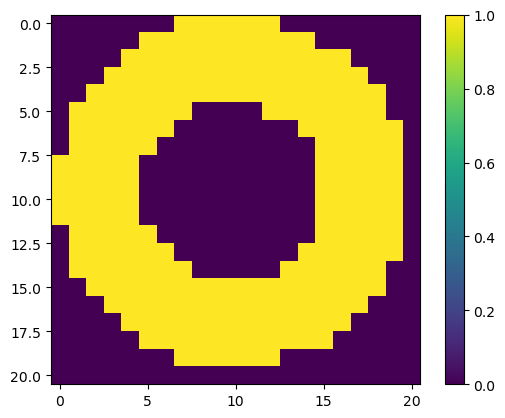

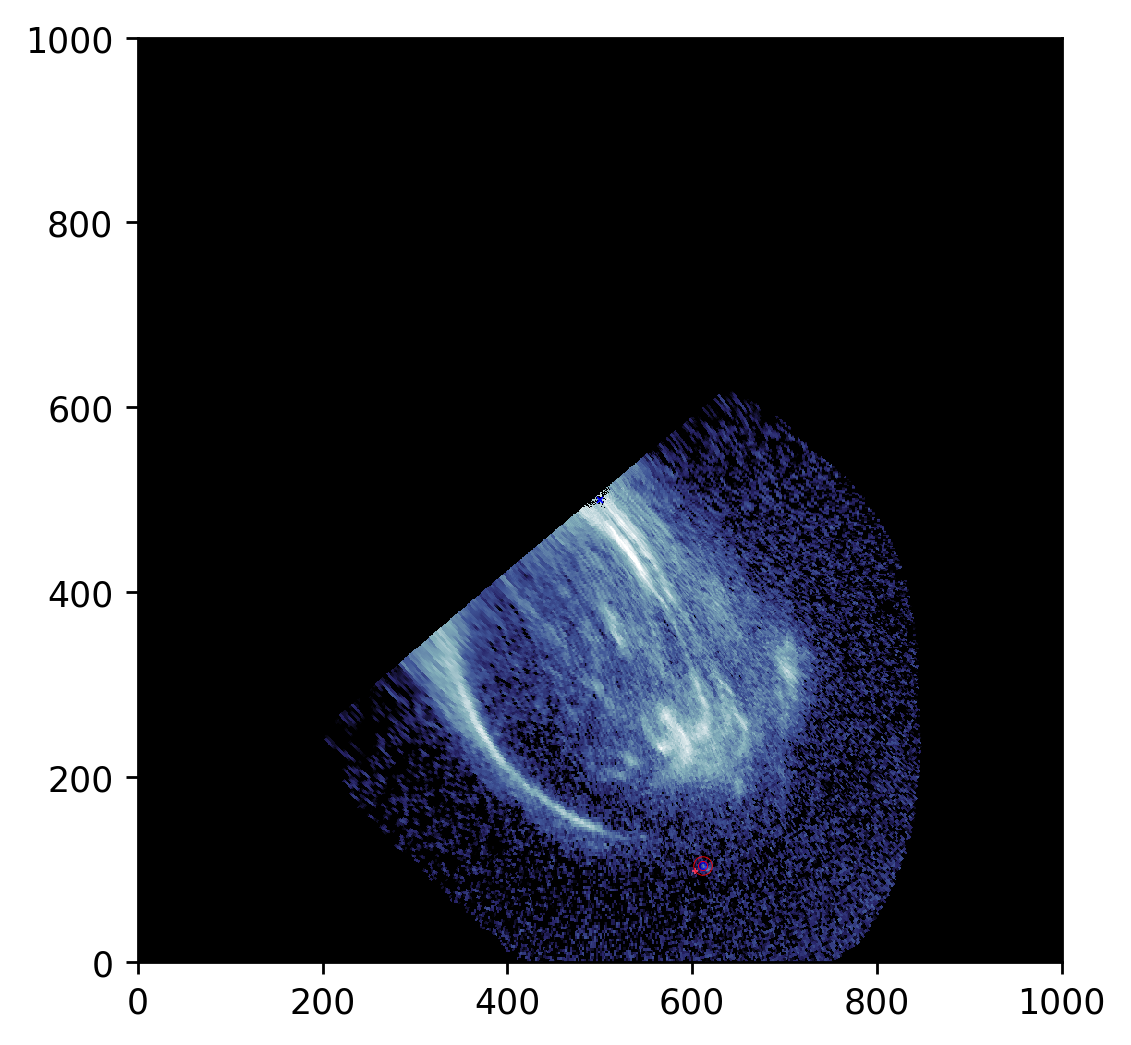

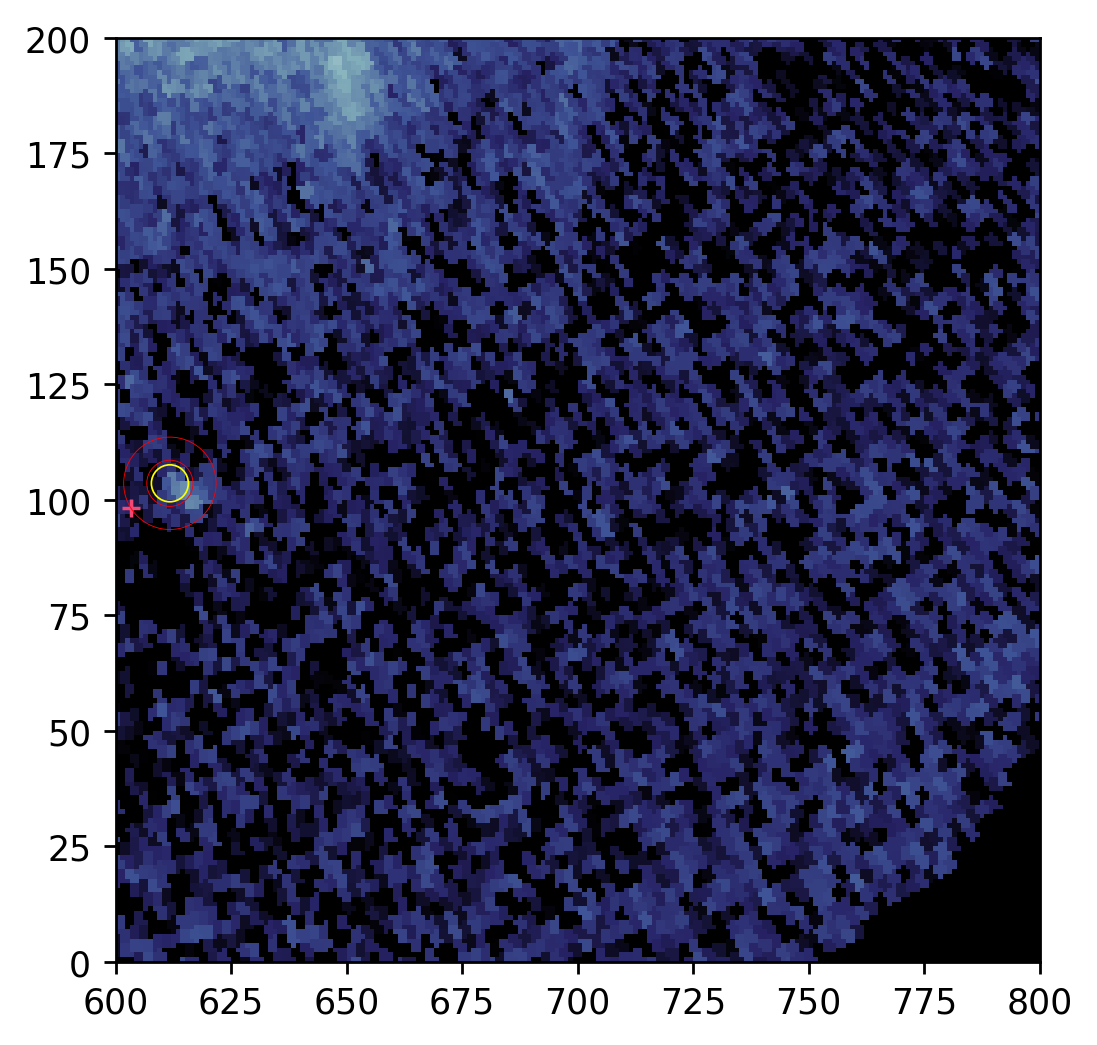

In [41]:
ftps3wlon = h.s3wlon_lin            # [deg]
ftps3lat = h.s3lat_lin              # [deg]
print('=== JRM33 Estimation ===')
print('Sys3,lat', ftps3wlon, ftps3lat)
print('Wlong [deg]', ftps3wlon)
print('Lat [deg]', ftps3lat)
if hem=='south':
    ftps3lat *= -1

ftpelon = 360-(ftps3wlon-90)        # [deg]
ftpcolat = 90-ftps3lat              # [deg]
ftpR = ftpcolat*(Npx/(2*extdeg))    # [px]
ftpR = (Npx/2)*(math.tan(math.radians(ftpcolat/2))/math.tan(math.radians((90-extdeg)/2)))     # [px]
print('extdeg', extdeg)
print('ftps3lat', ftps3lat)
ftpX = ftpR*np.cos(np.radians(ftpelon))         # [px]
ftpY = ftpR*np.sin(np.radians(ftpelon))         # [px]
ftpX += Npx/2
ftpY += Npx/2
# print(ftpcolat, ftpR, ftpX, ftpY)

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  # [px]
positions[:,0] += x0    # [px]
positions[:,1] += y0    # [px]

posarg0 = np.argmin(np.absolute((positions[:,0]-ftpX)**2 + (positions[:,1]-ftpY)**2))
print('=== The spot ===')
print('Nearest [px]:', posarg0, positions[posarg0,:])
print('Number of pixels [px]: ', sources['npix'][posarg0])
print('Brightness peak [kR]: ', sources['peak'][posarg0])
print('Brightness flux [kR]: ', sources['flux'][posarg0]*thres)

posX = positions[posarg0,0]-Npx/2
posY = positions[posarg0,1]-Npx/2
posR = math.sqrt(posX**2 + posY**2)             # [px]
poslat = posR*(2*extdeg/Npx)
poslat = math.degrees(2*math.atan2(posR*math.tan(0.5*math.radians(90-extdeg)), Npx/2))
postheta = math.atan2(posY,posX)-0.5*np.pi
# print('theta [deg]', math.degrees(postheta))
print('Wlong [deg]', -math.degrees(postheta))
print('Lat [deg]', 90-poslat)

# Aperture photometry
apertures = CircularAperture(positions[posarg0,:], r=4.)
rawflux = aperture_photometry(dimage, apertures)
# print(rawflux)

# 局所的な背景を測定する
# 各スポットを中心とした輪っかを作成
annulus_apertures = CircularAnnulus(positions[posarg0,:], r_in=5., r_out=10.)

# sigmaクリッピング法を用いる
# http://www.astroarts.com/products/stlimg7/support/faq-general/composite_methods-j.shtml
annulus_masks = annulus_apertures.to_mask(method='center')
annulus_data = annulus_masks.multiply(dimage)
annulus_data_1d = annulus_data[annulus_masks.data > 0]
_, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
bkg_median = median_sigclip
rawflux['annulus_median'] = bkg_median
rawflux['aper_bkg'] = bkg_median*apertures.area
rawflux['final_phot'] = rawflux['aperture_sum'] - rawflux['aper_bkg']
print(rawflux['final_phot'])
plt.imshow(annulus_masks)
plt.colorbar()
plt.show()




# Plots
fig, ax = plt.subplots(dpi=250)
ax.set_aspect('equal')
# ax.pcolormesh(dimage, cmap=TScmap().MIDNIGHTS(), vmin=median-5*std, vmax=median+5*std, zorder=0.1)
ax.pcolormesh(dimage, cmap=TScmap().MIDNIGHTS(),
              norm=colors.LogNorm(vmin=10, vmax=2000),
              zorder=0.1)
ax.plot(ftpX, ftpY,
        markersize=2, marker='+', markerfacecolor='#f24875',
        markeredgecolor='#f24875', markeredgewidth=0.5, zorder=1)
ax.plot(Npx/2, Npx/2,
        markersize=2, marker='x', markerfacecolor='blue',
        markeredgecolor='blue', markeredgewidth=0.5, zorder=1)
apertures.plot(color='blue', lw=1.0, alpha=0.6)
annulus_apertures.plot(color='red', lw=0.25)
plt.show()

fig, ax = plt.subplots(dpi=250)
ax.set_aspect('equal')
ax.set_xlim(x0, x1)
ax.set_ylim(y0, y1)
# ax.pcolormesh(dimage, cmap=TScmap().MIDNIGHTS(), vmin=median-5*std, vmax=median+5*std, zorder=0.1)
ax.pcolormesh(dimage, cmap=TScmap().MIDNIGHTS(),
              norm=colors.LogNorm(vmin=10, vmax=2000),
              zorder=0.1)
ax.plot(ftpX, ftpY,
        markersize=5, marker='+', markerfacecolor='#f24875',
        markeredgecolor='#f24875', markeredgewidth=1, zorder=1)
ax.plot(Npx/2, Npx/2,
        markersize=2, marker='x', markerfacecolor='blue',
        markeredgecolor='blue', markeredgewidth=0.5, zorder=1)
apertures.plot(color='yellow', lw=0.5, alpha=1.0)
annulus_apertures.plot(color='red', lw=0.25, alpha=1.0)
plt.show()

 id      xcenter      ...     final_phot      final_phot_ave  
           pix        ...                                     
--- ----------------- ... ----------------- ------------------
  1 611.7311858610507 ... 5171.723821207614 102.88817630641216
   aperture_sum  
-----------------
6798.064825341455
  annulus_median 
-----------------
32.35502624511719
     aper_bkg     
------------------
1626.3410041338416
  final_phot_ave  
------------------
102.88817630641216


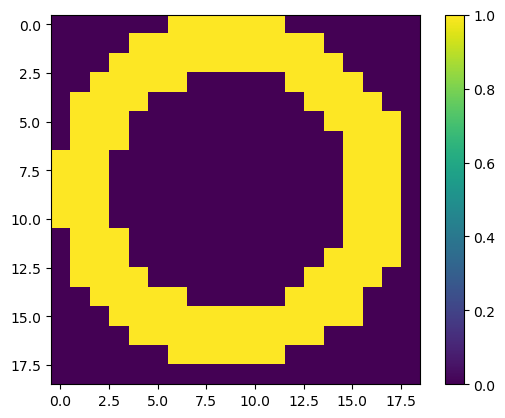

In [42]:
# Aperture photometry
apertures = CircularAperture(positions[posarg0,:], r=4.)
rawflux = aperture_photometry(dimage, apertures)
# print(rawflux)

# 局所的な背景を測定する
# 各スポットを中心とした輪っかを作成
annulus_apertures = CircularAnnulus(positions[posarg0,:], r_in=6., r_out=9.)

# sigmaクリッピング法を用いる
# http://www.astroarts.com/products/stlimg7/support/faq-general/composite_methods-j.shtml
# ここではガウシアン開口ではなくただの円開口を用いる
# rawfluxには開口内の合計カウント値が入っているので、バックグラウンドとして`bkg_median*apertures.area`
# を作成し、`rawflux['aperture_sum']`からさっ引く。
annulus_masks = annulus_apertures.to_mask(method='center')
annulus_data = annulus_masks.multiply(dimage)
annulus_data_1d = annulus_data[annulus_masks.data > 0]  # 輪っか内部の値だけ抽出
_, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
bkg_median = median_sigclip
rawflux['annulus_median'] = bkg_median
rawflux['aper_bkg'] = bkg_median*apertures.area
rawflux['final_phot'] = rawflux['aperture_sum'] - rawflux['aper_bkg']
rawflux['final_phot_ave'] = rawflux['final_phot']/apertures.area
print(rawflux)
print(rawflux['aperture_sum'])
print(rawflux['annulus_median'])
print(rawflux['aper_bkg'])
print(rawflux['final_phot_ave'])
plt.imshow(annulus_masks)
plt.colorbar()
plt.show()

In [43]:
def Aperture(IMAGE, POSITION):
    """_summary_

    Args:
        IMAGE (2d ndarray): raw image
        POSITION (1d array): position of one spot in the raw image

    Returns:
        apertures (CircularAperture): \n
        rawflux (QTable): QTable including the spot position and the final photometry averaged in pixels. \n
            `['id']` \n
            `['xcenter']` : x position [px] \n
            `['ycenter']` : y position [px] \n
            `['aperture_sum']` : summation of brightness in the target aperture
            `['annulus_median']` : the median inside the donut \n
            `['aper_bkg']` : summation of the median inside the donut \n
            `['final_phot'] = rawflux['aperture_sum'] - rawflux['aper_bkg']` \n
            `['final_phot_ave'] = rawflux['final_phot']/apertures.area`
            
    """
    # Aperture photometry
    apertures = CircularAperture(POSITION, r=4.)
    rawflux = aperture_photometry(IMAGE, apertures)

    # Make a donut to calculate the local background in.
    annulus_apertures = CircularAnnulus(POSITION, r_in=5.5, r_out=9.)

    # Sigma-clipping
    # http://www.astroarts.com/products/stlimg7/support/faq-general/composite_methods-j.shtml
    annulus_masks = annulus_apertures.to_mask(method='center')

    # Mask inside the donut
    annulus_data = annulus_masks.multiply(IMAGE)
    annulus_data_1d = annulus_data[annulus_masks.data > 0]  # 輪っか内部の値だけ抽出

    # Calculate the median as the local background
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median = median_sigclip*1.0

    # Add results to the rawflux data
    rawflux['annulus_median'] = bkg_median
    rawflux['aper_bkg'] = bkg_median*apertures.area
    rawflux['final_phot'] = rawflux['aperture_sum'] - rawflux['aper_bkg']
    rawflux['final_phot_ave'] = rawflux['final_phot']/apertures.area
    
    return apertures, rawflux


 id      xcenter      ...     final_phot      final_phot_ave  
           pix        ...                                     
--- ----------------- ... ----------------- ------------------
  1 611.7311858610507 ... 5227.344047100361 103.99470554225199
   aperture_sum  
-----------------
6798.064825341455
  annulus_median  
------------------
31.248497009277344
     aper_bkg     
------------------
1570.7207782410933
  final_phot_ave  
------------------
103.99470554225199


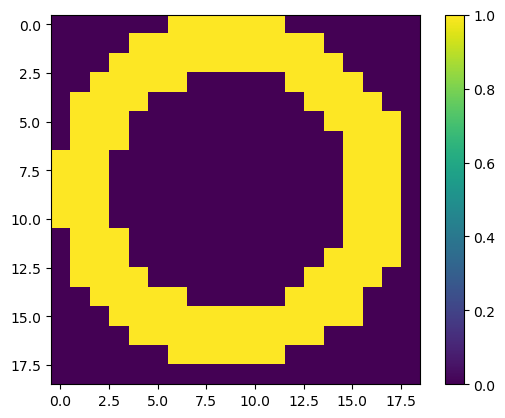

In [44]:
# Aperture photometry
aperture, rawflux = Aperture(dimage, positions[posarg0,:])
print(rawflux)
print(rawflux['aperture_sum'])
print(rawflux['annulus_median'])
print(rawflux['aper_bkg'])
print(rawflux['final_phot_ave'])
plt.imshow(annulus_masks)
plt.colorbar()
plt.show()